In [82]:
# !pip install scikit-learn
# !pip install optbinning
# !pip install xgboost
!pip install optuna
# !brew install libomp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00 MB/s eta 0:00:01


In [177]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import optuna

from optbinning import BinningProcess
from optbinning import OptimalBinning

from typing import Dict, List, Tuple, Literal
import os
import pickle
import json

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Setup

In [53]:
# Declare Relative Path
PATH_DIR_DATASET = "../artifact/dataset"
PATH_DIR_MODEL = "../artifact/model"

RANDOM_STATE = 42

## Utility Functions

In [80]:
def dump_pickle(object_:object, dst:str):
    """
    Dump pickle object into a pkl file
    """
    with open(dst, 'wb') as f:
        pickle.dump(object_, f)

def get_positive_rate(
    df: pd.DataFrame, 
    label_col: str,
    positive_value=1
) -> float:
    """
    Return a positive rate 
    """
    pos_count = df[df[label_col] == positive_value].shape[0]  
    total_count = df.shape[0]  

    return pos_count / total_count if total_count > 0 else 0

def split_into_x_and_y(df:pd.DataFrame)->Tuple[pd.DataFrame,pd.Series]:
    """
    Segregate dataframe into usable X and y
    """
    X = df.drop(["Churn","customerID"],axis=1)
    y = df["Churn"]
    return X, y 

def get_class_weight_for_binary(y_train:pd.Series,is_inverse:bool=True)->float:
    """
    Calculate the class weight for binary classification.
    Args:
    - is_inverse : True if use for xgboost
    """
    unique_classes = np.unique(y_train)
    assert len(unique_classes) == 2, "This function is for binary class only"
    
    weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
    class_weight = weights[1] / weights[0] if is_inverse else weights[1] / (weights[0] + weights[1])
    class_weight = float(class_weight)
    return class_weight
    
def get_class_weight_mapping(y_train:pd.Series)->Dict:
    """
    Compute class weights mapping
    """
    unique_classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
    class_weight_mapping = {int(cls): float(weights[i]) for i, cls in enumerate(unique_classes)}
    return class_weight_mapping
 

## Dataset

In [8]:
def print_unique_values(
    df: pd.DataFrame, max_display: int = 10
):
    """
    Display the unique values for each column in the dataset.

    If the number of unique values exceeds max_display, only the first max_display values are shown.
    """
    for column in df.columns: 
        print(f"Unique values in '{column}':")
        unique_values = df[column].unique()
        
        if len(unique_values) > max_display:
            print(f"(Showing only {max_display} out of {len(unique_values)} unique values)")
            print(unique_values[:max_display], end="\n\n")
        else:
            print(unique_values, end="\n\n")

def get_null_percentage(df):
    """
    Calculate the percentage of null values in each column of a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.Series: A Series containing the percentage of null values per column.
    """
    return (df.isnull().sum() / len(df)) * 100

### Import
- Get the dataset from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn), but for easier access, download it from this [Github Repository](https://github.com/ShefaaSaied/Telco-customer-churn-prediction/tree/main/Dataset).

In [9]:
!curl https://raw.githubusercontent.com/ShefaaSaied/Telco-customer-churn-prediction/refs/heads/main/Dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv\
-o ../artifact/dataset/telco_churn_customer.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
     0 --:--:-- --:--:-- --:--:--  976k     0  0:00:01 --:--:--  0:00:01  697k


In [10]:
import pandas as pd

path_dataset = os.path.join(PATH_DIR_DATASET, "telco_churn_customer.csv")
df = pd.read_csv(path_dataset)

### Data Sanity Check

In [11]:
# Check if all customer ID is unique, no duplication
len(df["customerID"].unique()) == len(df)

True

In [12]:
# The data type of this column is categorical because a space (” “) appears. Therefore, we are required to impute it with zero.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

### EDA
- Check Completion of dataset (Null)

In [13]:
display(get_null_percentage(df))

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

- Print Possible value (Null)

In [14]:
print_unique_values(df)

Unique values in 'customerID':
(Showing only 10 out of 7043 unique values)
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU'
 '9305-CDSKC' '1452-KIOVK' '6713-OKOMC' '7892-POOKP' '6388-TABGU']

Unique values in 'gender':
['Female' 'Male']

Unique values in 'SeniorCitizen':
[0 1]

Unique values in 'Partner':
['Yes' 'No']

Unique values in 'Dependents':
['No' 'Yes']

Unique values in 'tenure':
(Showing only 10 out of 73 unique values)
[ 1 34  2 45  8 22 10 28 62 13]

Unique values in 'PhoneService':
['No' 'Yes']

Unique values in 'MultipleLines':
['No phone service' 'No' 'Yes']

Unique values in 'InternetService':
['DSL' 'Fiber optic' 'No']

Unique values in 'OnlineSecurity':
['No' 'Yes' 'No internet service']

Unique values in 'OnlineBackup':
['Yes' 'No' 'No internet service']

Unique values in 'DeviceProtection':
['No' 'Yes' 'No internet service']

Unique values in 'TechSupport':
['No' 'Yes' 'No internet service']

Unique values in 'StreamingTV':
['No' 'Yes' 'No internet

In [15]:
# Convery binary column to 0 or 1
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
# df["Partner"] = df["Partner"].map({"Yes": 1, "No": 0})
# df["Dependents"] = df["Dependents"].map({"Yes": 1, "No": 0})
# df["PhoneService"] = df["PhoneService"].map({"Yes": 1, "No": 0})
# df["PaperlessBilling"] = df["PaperlessBilling"].map({"Yes": 1, "No": 0})

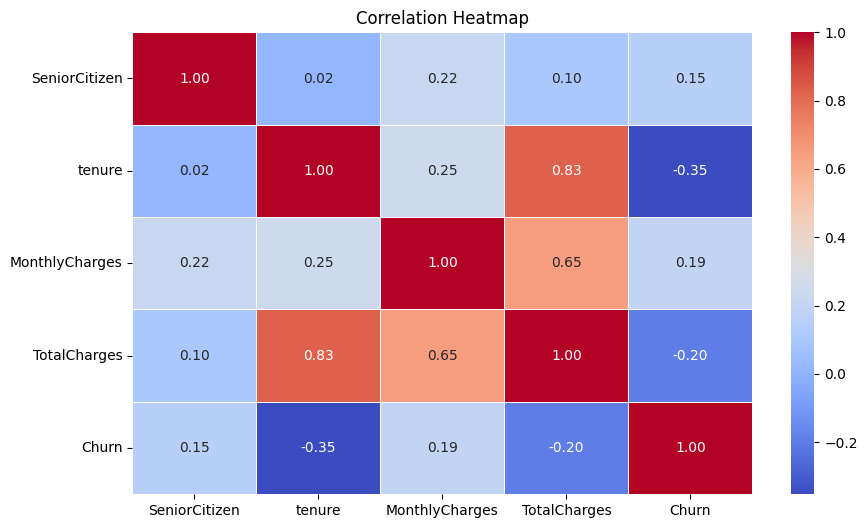

In [16]:
# Compute correlation
df_num = df.select_dtypes(include=['int','float64'])
numeric_features = list(df_num.columns)
correlation_matrix = df_num.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

<Axes: xlabel='Churn', ylabel='SeniorCitizen'>

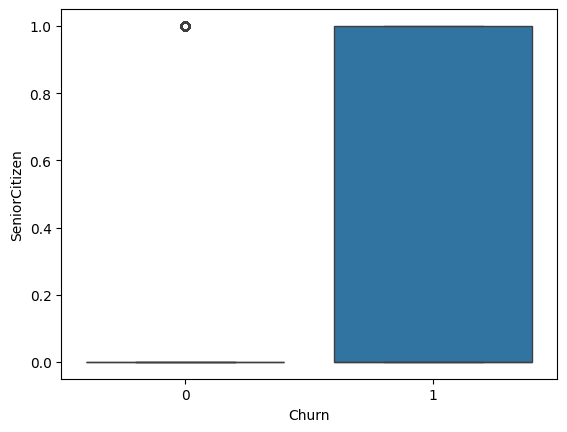

In [17]:
sns.boxplot(x=df["Churn"], y=df["SeniorCitizen"])

In [18]:
categorical_features = [i for i in df.columns if i not in numeric_features]

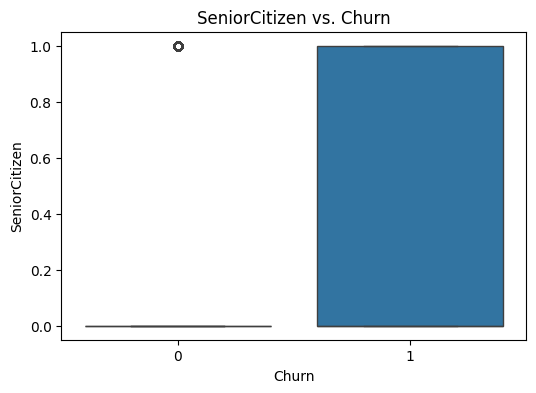

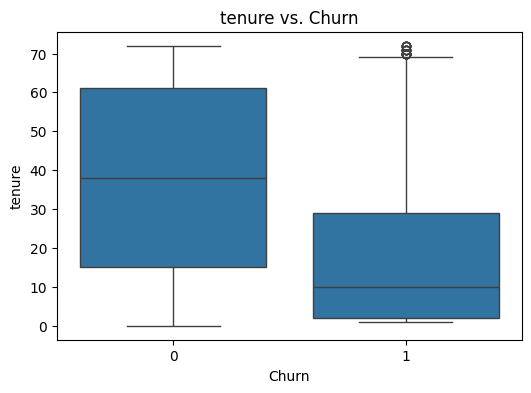

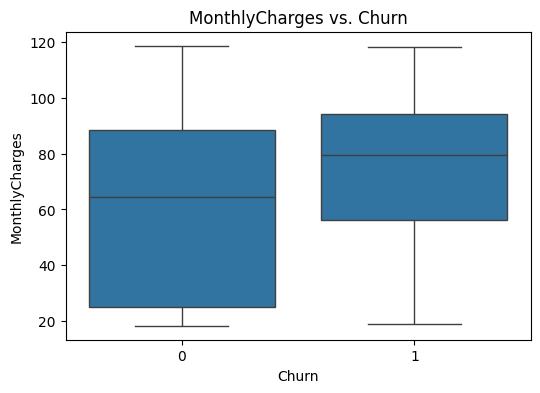

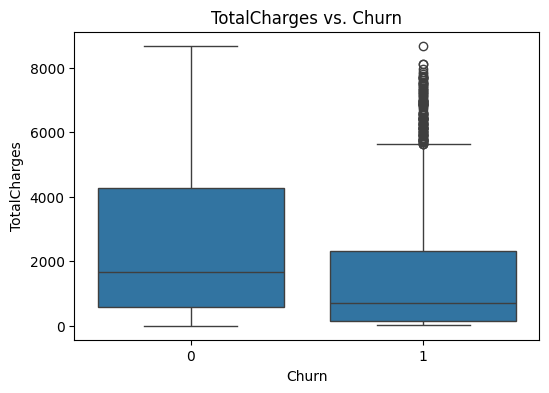

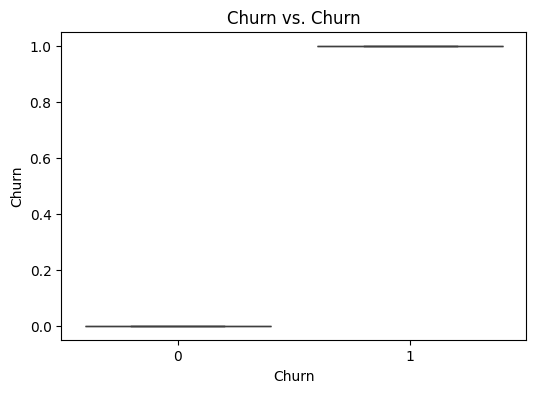

In [19]:
for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df["Churn"], y=df[feature])
    plt.title(f"{feature} vs. Churn")
    plt.show()

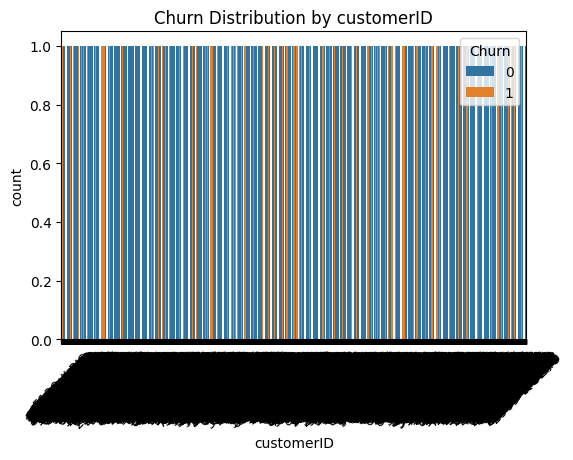

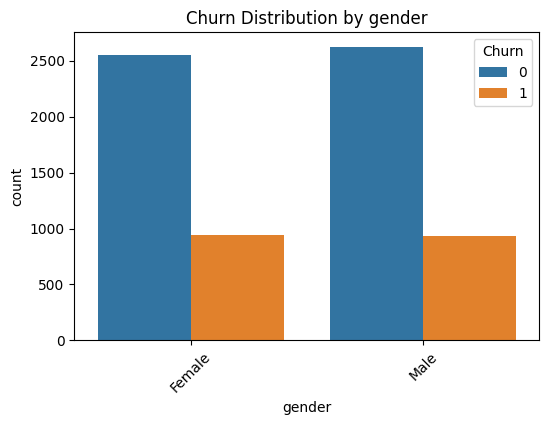

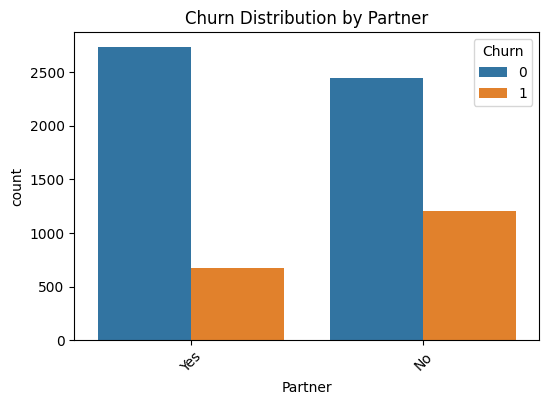

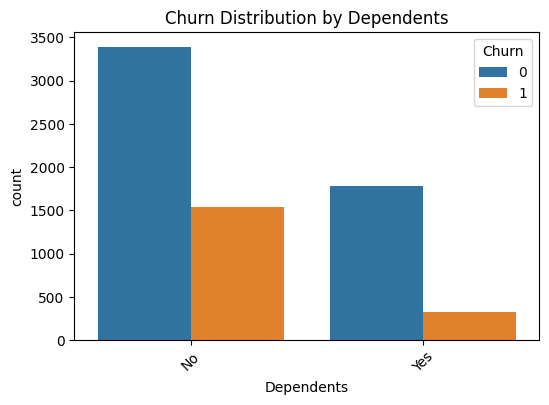

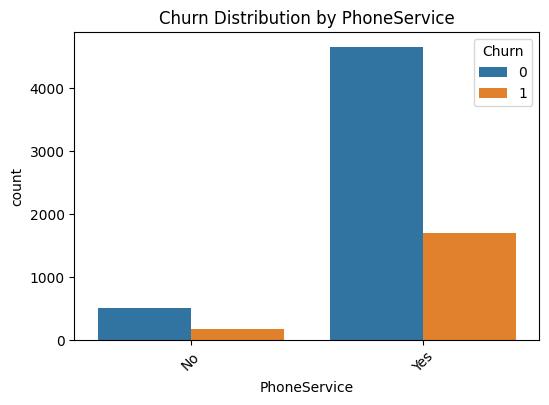

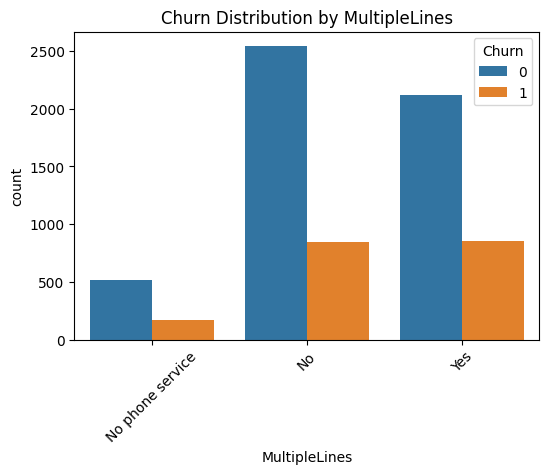

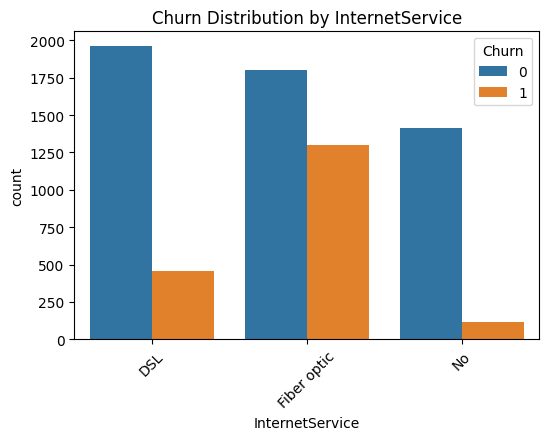

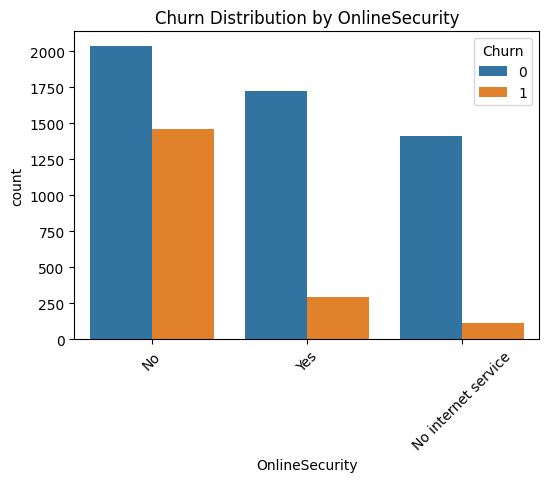

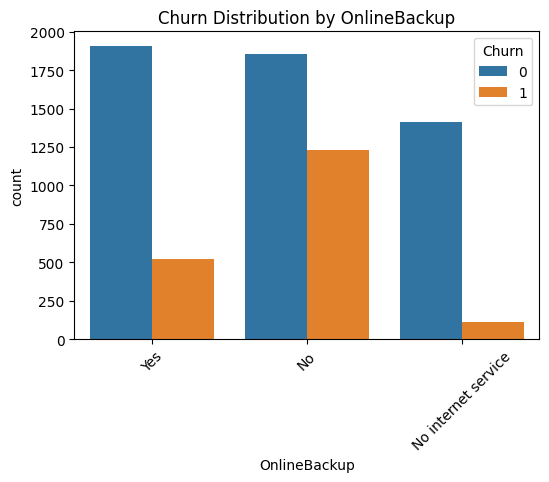

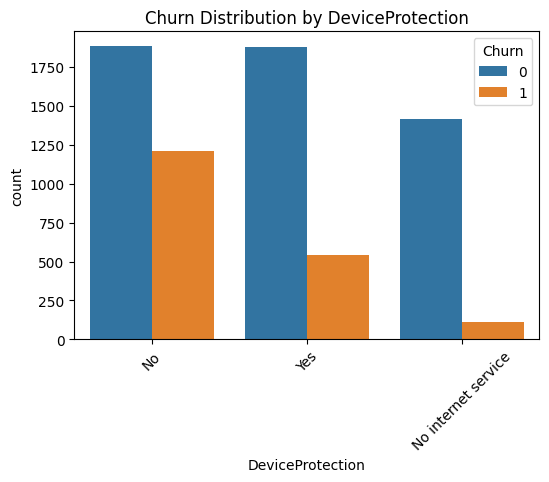

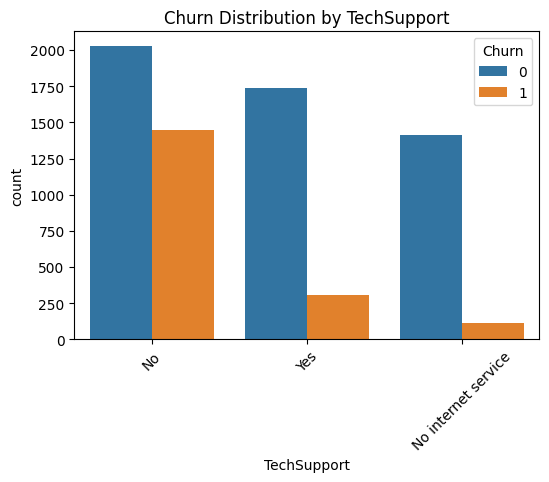

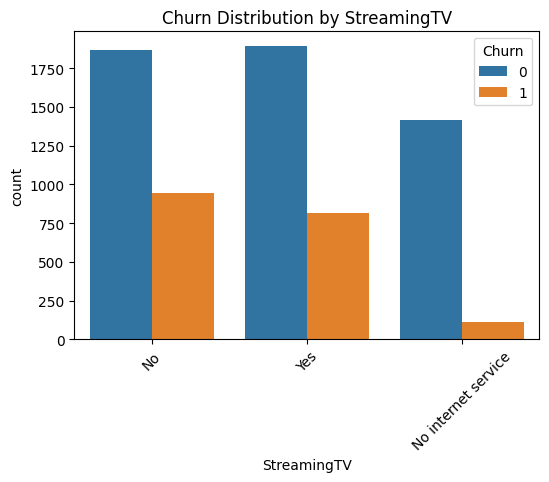

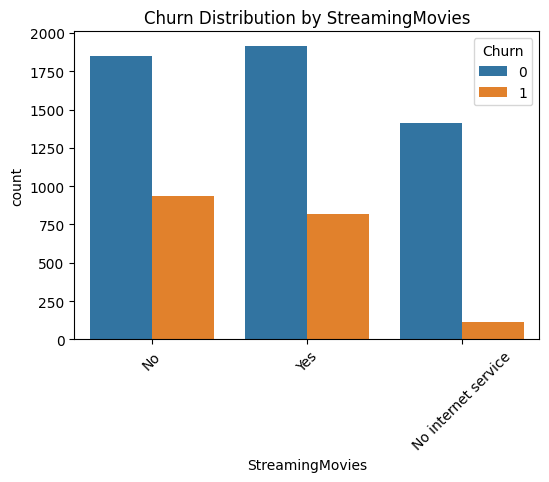

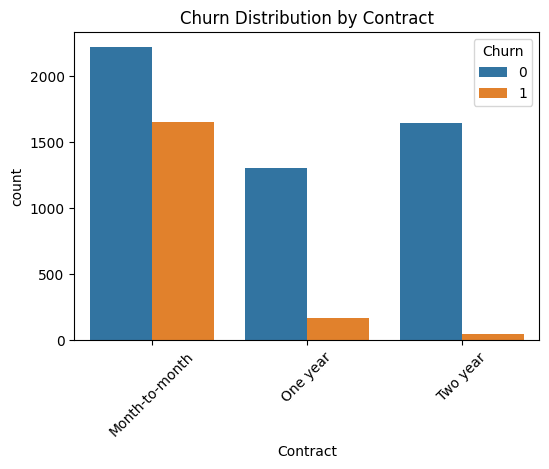

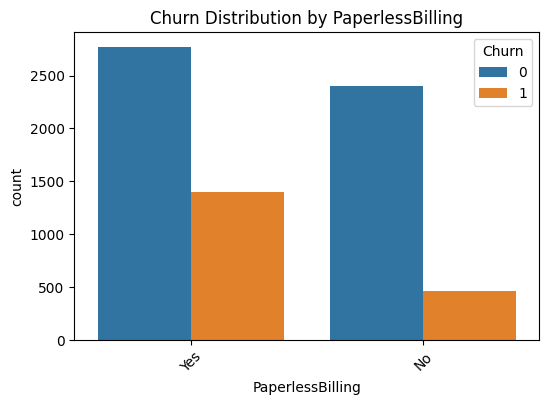

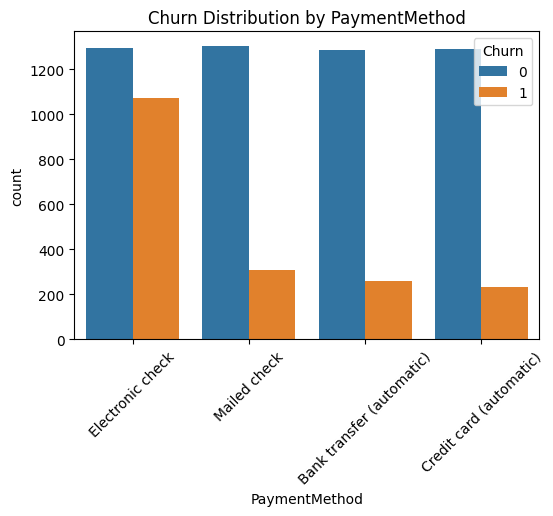

In [20]:
for feature in categorical_features:
    if categorical_features == "customerID":
        continue
    plt.figure(figsize=(6, 4))
    sns.countplot(x=feature, hue="Churn", data=df)
    plt.title(f"Churn Distribution by {feature}")
    plt.xticks(rotation=45)
    plt.show()

### Clean
1. The Internet-related columns appear to contain “No internet service.” We need to verify if this aligns with the “InternetService” column.

In [21]:
list_col_internet_details = list(df.columns[9:-6])

# Data Sanity Check
for col in list_col_internet_details:
    df_subset = df.query(f"{col} == 'No internet service'")
    value_counts = df_subset["InternetService"].value_counts()
    assert value_counts.index[0] == 'No' and len(value_counts) == 1, f"This column {col} does not match with InternetService, Please Recheck !"


df_subset = df.query(f"InternetService == 'No'")
for col in list_col_internet_details:
    value_counts = df_subset[col].value_counts()
    assert value_counts.index[0] == 'No internet service' and len(value_counts) == 1, f"This column {col} does not match with InternetService, Please Recheck !"

### Feature Metadata
- Profiling the predictor (data type) and target

In [22]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

### Train/Test Split

In [23]:
def calculate_psi_numerical(expected: pd.Series, actual: pd.Series, buckettype='bins', buckets=10):
    """
    Calculate the Population Stability Index (PSI) between two distributions.

    Args:
        expected (pd.Series): The expected distribution (e.g., training data).
        actual (pd.Series): The actual distribution (e.g., validation or test data).
        buckettype (str): Method to divide data ('bins' for equal-width bins, 'quantiles' for quantiles).
        buckets (int): Number of buckets to divide the data into.

    Returns:
        float: The PSI value between the two distributions.
    """
    # Create bins or quantiles
    if buckettype == 'bins':
        breaks = np.linspace(expected.min(), expected.max(), buckets + 1)
        expected_binned = pd.cut(expected, bins=breaks, include_lowest=True)
        actual_binned = pd.cut(actual, bins=breaks, include_lowest=True)
    elif buckettype == 'quantiles':
        expected_binned = pd.qcut(expected, q=buckets, labels=False, duplicates='drop')
        actual_binned = pd.qcut(actual, q=buckets, labels=False, duplicates='drop')

    # Calculate the expected and actual distributions using Series.value_counts()
    expected_dist = pd.Series(expected_binned).value_counts(normalize=True)
    actual_dist = pd.Series(actual_binned).value_counts(normalize=True)

    # Calculate PSI
    psi = 0
    for i in range(buckets):
        expected_freq = expected_dist.get(i, 0)
        actual_freq = actual_dist.get(i, 0)
        if expected_freq == 0 or actual_freq == 0:
            continue
        psi += (expected_freq - actual_freq) * np.log(expected_freq / actual_freq)

    return psi

def calculate_psi_categorical(expected: pd.Series, actual: pd.Series):
    """
    Calculate the Population Stability Index (PSI) for categorical features.

    Args:
        expected (pd.Series): The expected distribution (e.g., training data).
        actual (pd.Series): The actual distribution (e.g., validation or test data).

    Returns:
        float: The PSI value between the two categorical distributions.
    """
    # Calculate the distribution for expected and actual categorical values
    expected_dist = expected.value_counts(normalize=True)
    actual_dist = actual.value_counts(normalize=True)

    # Calculate PSI
    psi = 0
    all_categories = set(expected_dist.index).union(set(actual_dist.index))  # Include all categories in both distributions

    for category in all_categories:
        expected_freq = expected_dist.get(category, 0)
        actual_freq = actual_dist.get(category, 0)
        if expected_freq == 0 or actual_freq == 0:
            continue
        psi += (expected_freq - actual_freq) * np.log(expected_freq / actual_freq)

    return psi
    

def color_emoji_for_psi(psi_value: float) -> str:
    """
    Returns a colored emoji based on the PSI value.

    Args:
        psi_value (float): The calculated PSI value.

    Returns:
        str: A colored emoji based on the PSI value.
    """
    if psi_value < 0.1:
        return "🟩"  # Green for < 0.1
    elif psi_value < 0.25:
        return "🟨"  # Yellow for 0.1 <= PSI < 0.25
    else:
        return "🟥"  # Red for PSI >= 0.25


In [24]:
def stratified_split(
    data: pd.DataFrame, label: str, splits: list = [0.8, 0.1, 0.1], random_state: int = 42
):
    """ 
    Divides a DataFrame into training, validation, and test sets, ensuring class balance.

    Args:
        data (pd.DataFrame): The dataset to split.
        label (str): The column containing class labels.
        splits (list): Proportions for train, validation, and test sets.
        random_state (int): Seed for reproducibility.

    Returns:
        pd.DataFrame: DataFrames for training, validation, and testing.
    """
    assert sum(splits) == 1, "Split proportions must sum to 1"

    train_ratio, val_ratio, test_ratio = splits
    temp_ratio = val_ratio + test_ratio

    X = data.drop(columns=[label])
    y = data[label]

    # First, split into training and temporary set
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=temp_ratio, stratify=y, random_state=random_state
    )

    # Further split temporary set into validation and test
    val_proportion = val_ratio / temp_ratio
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_ratio / temp_ratio), stratify=y_temp, random_state=random_state
    )

    # Reattach label column and tag dataset type
    X_train[label] = y_train
    # X_train["split"] = "train"

    X_val[label] = y_val
    # X_val["split"] = "validation"

    X_test[label] = y_test
    # X_test["split"] = "test"

    return X_train, X_val, X_test

In [25]:
df_train, df_val, df_test = stratified_split(df, label="Churn")

- Interpretation of PSI:
	- PSI < 0.1: No significant change in the distribution.
	- 0.1 ≤ PSI < 0.25: Minor change in the distribution.
	- PSI ≥ 0.25: Significant shift in the distribution.

In [26]:
# List of numeric columns in the dataset (you can also filter based on other criteria if needed)
numeric_features = list(df.select_dtypes(include=['number']).columns)
categorical_features = list(df.select_dtypes(include=['object']).columns)

numeric_features.remove("Churn")
categorical_features.remove("customerID")

# Loop through each numeric feature and calculate PSI between train, validation, and test
print("Numerical Features : ")
for feature in numeric_features:
    psi_train_population = calculate_psi_numerical(df[feature], df_train[feature])
    psi_train_val = calculate_psi_numerical(df_train[feature], df_val[feature])
    psi_train_test = calculate_psi_numerical(df_train[feature], df_test[feature])
    psi_val_test = calculate_psi_numerical(df_val[feature], df_test[feature])
    
    # Print PSI results for each feature
    print(f"PSI for {feature}:")
    print(f"{color_emoji_for_psi(psi_train_population)} - Train vs Population: {psi_train_population:.4f}")
    print(f"{color_emoji_for_psi(psi_train_val)} - Train vs Validation: {psi_train_val:.4f}")
    print(f"{color_emoji_for_psi(psi_train_test)} - Train vs Test: {psi_train_test:.4f}")
    print(f"{color_emoji_for_psi(psi_val_test)} - Validation vs Test: {psi_val_test:.4f}")
    print("-" * 40)


print("Categorical Features : ")
for feature in categorical_features:
    psi_train_population = calculate_psi_categorical(df[feature], df_train[feature])
    psi_train_val = calculate_psi_categorical(df_train[feature], df_val[feature])
    psi_train_test = calculate_psi_categorical(df_train[feature], df_test[feature])
    psi_val_test = calculate_psi_categorical(df_val[feature], df_test[feature])
    
    # Print PSI results for each feature
    print(f"PSI for {feature}:")
    print(f"{color_emoji_for_psi(psi_train_population)} - Train vs Population: {psi_train_population:.4f}")
    print(f"{color_emoji_for_psi(psi_train_val)} - Train vs Validation: {psi_train_val:.4f}")
    print(f"{color_emoji_for_psi(psi_train_test)} - Train vs Test: {psi_train_test:.4f}")
    print(f"{color_emoji_for_psi(psi_val_test)} - Validation vs Test: {psi_val_test:.4f}")
    print("-" * 40)

Numerical Features : 
PSI for SeniorCitizen:
🟩 - Train vs Population: 0.0000
🟩 - Train vs Validation: 0.0001
🟩 - Train vs Test: 0.0004
🟩 - Validation vs Test: 0.0001
----------------------------------------
PSI for tenure:
🟩 - Train vs Population: 0.0005
🟩 - Train vs Validation: 0.0507
🟩 - Train vs Test: 0.0000
🟩 - Validation vs Test: 0.0495
----------------------------------------
PSI for MonthlyCharges:
🟩 - Train vs Population: 0.0000
🟩 - Train vs Validation: 0.0000
🟩 - Train vs Test: 0.0000
🟩 - Validation vs Test: 0.0000
----------------------------------------
PSI for TotalCharges:
🟩 - Train vs Population: 0.0000
🟩 - Train vs Validation: 0.0068
🟩 - Train vs Test: 0.0025
🟩 - Validation vs Test: 0.0171
----------------------------------------
Categorical Features : 
PSI for gender:
🟩 - Train vs Population: 0.0000
🟩 - Train vs Validation: 0.0000
🟩 - Train vs Test: 0.0015
🟩 - Validation vs Test: 0.0015
----------------------------------------
PSI for Partner:
🟩 - Train vs Population: 0

### Feature Selection

In [27]:
def get_optimal_bin_model(X:pd.DataFrame, y, max_num_bin=10):
    """
    Return a fit binning model
    """
    dict_binning_fit_params = {}
    num_bins = max_num_bin
        
    binning_model = BinningProcess(
        list(X.columns),
        categorical_variables=list(X.select_dtypes(include='object').columns),
        max_n_bins=max_num_bin,
        min_bin_size=0.05,
        n_jobs=-1,
        binning_fit_params=dict_binning_fit_params
    )
    binning_model.fit(X, y)
    
    return binning_model

def plot_binning_process(binning_model,X):
    """
    Plot binning result for all column with its event rate
    """
    for feature in X.columns:
        build = binning_model.get_binned_variable(feature)
        build.binning_table.build()        
        build.binning_table.plot(metric = 'event_rate', show_bin_labels=True)

In [44]:
X_train, y_train = split_into_x_and_y(df_train)

In [29]:
binning_model = get_optimal_bin_model(X_train, y_train, max_num_bin=10)

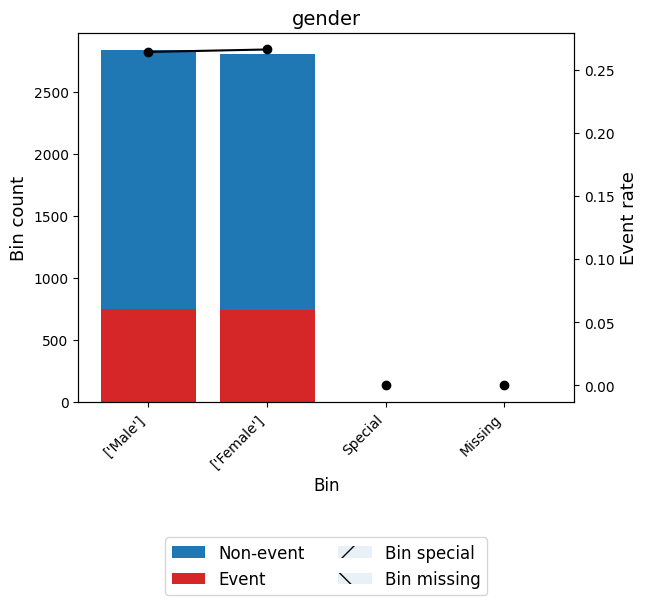

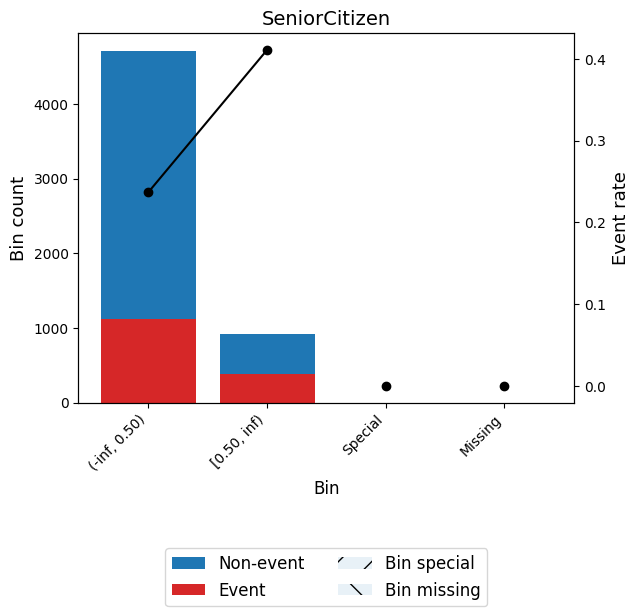

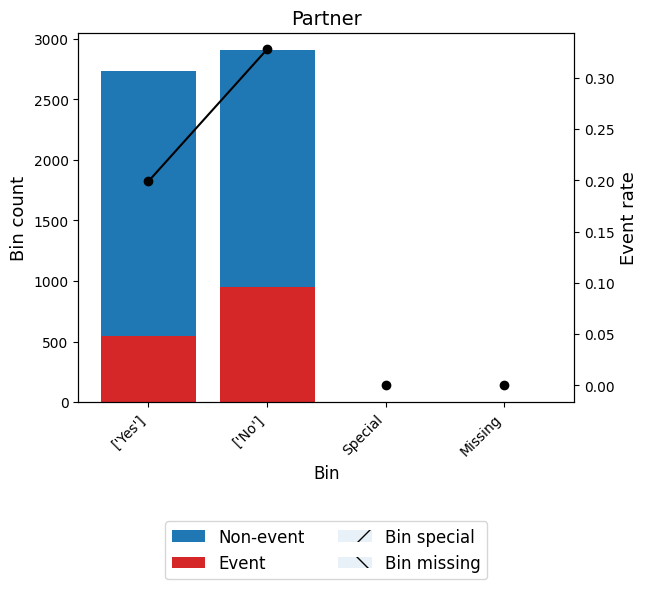

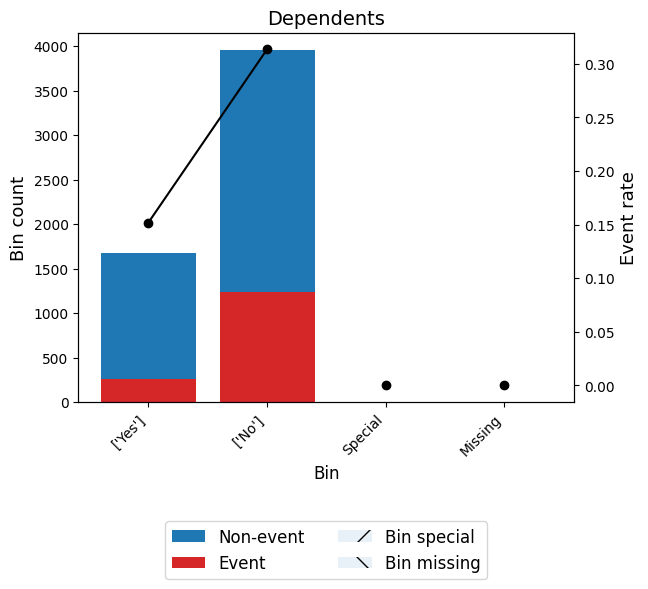

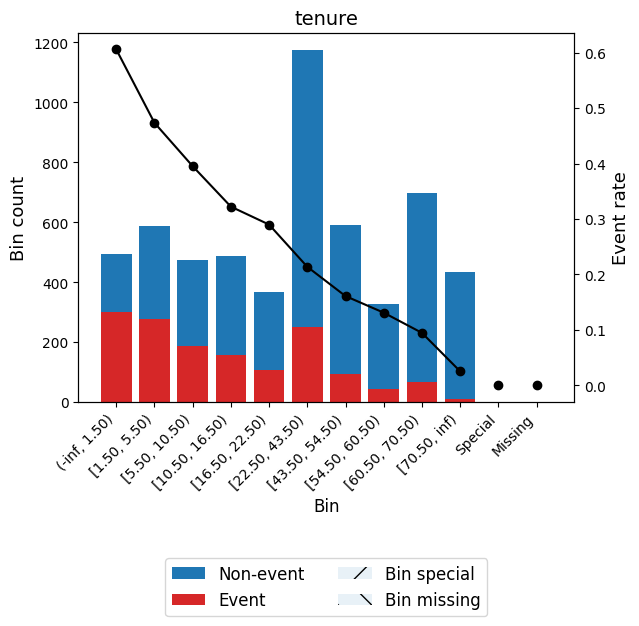

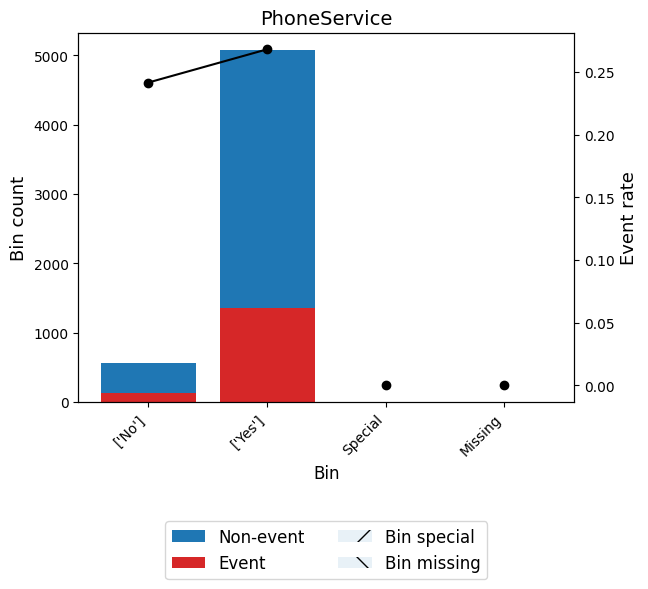

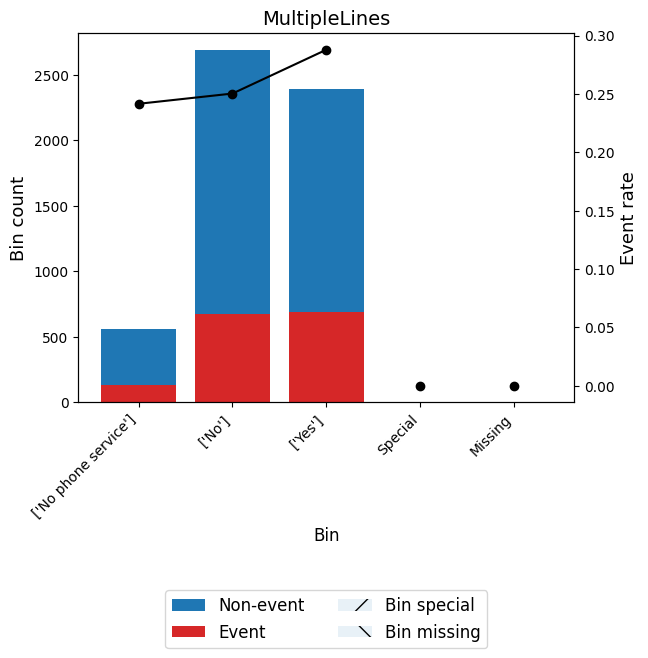

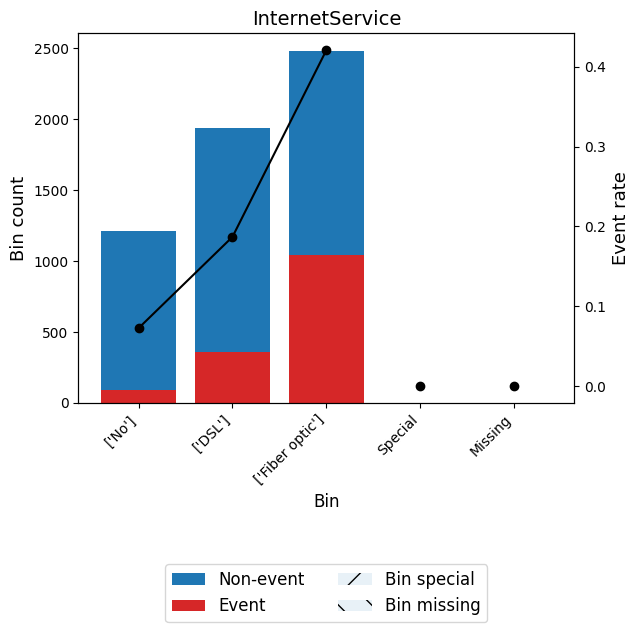

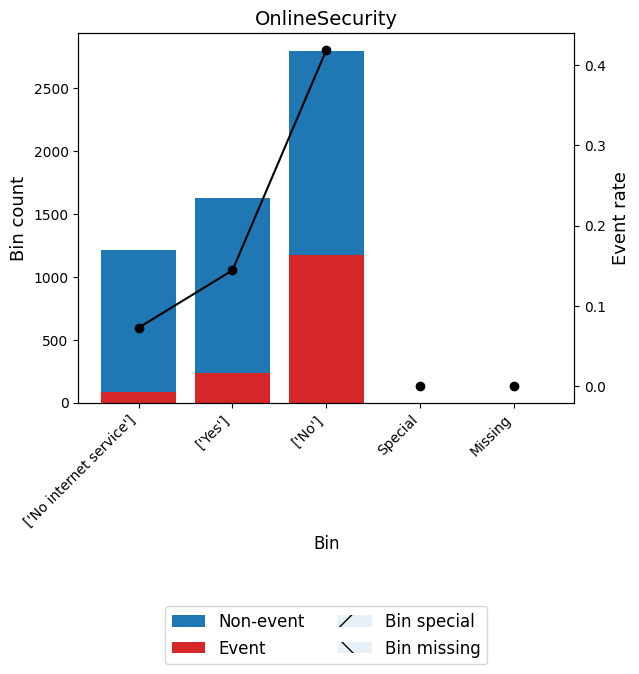

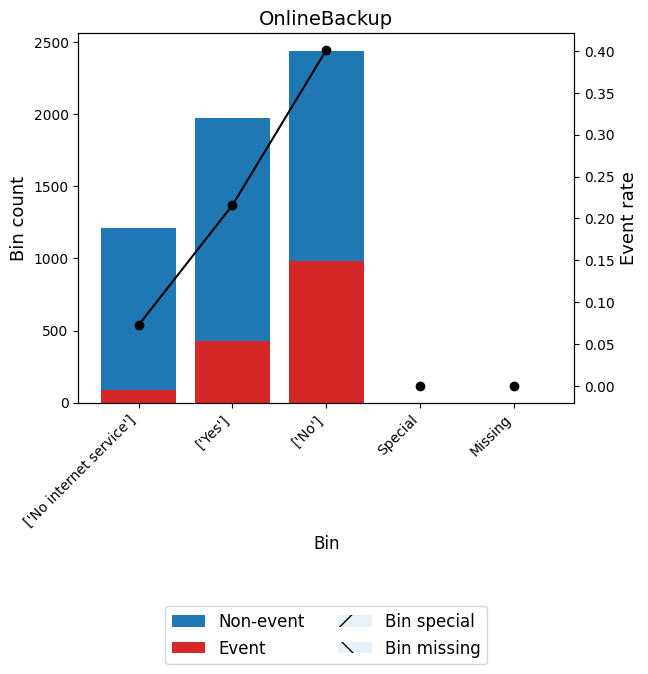

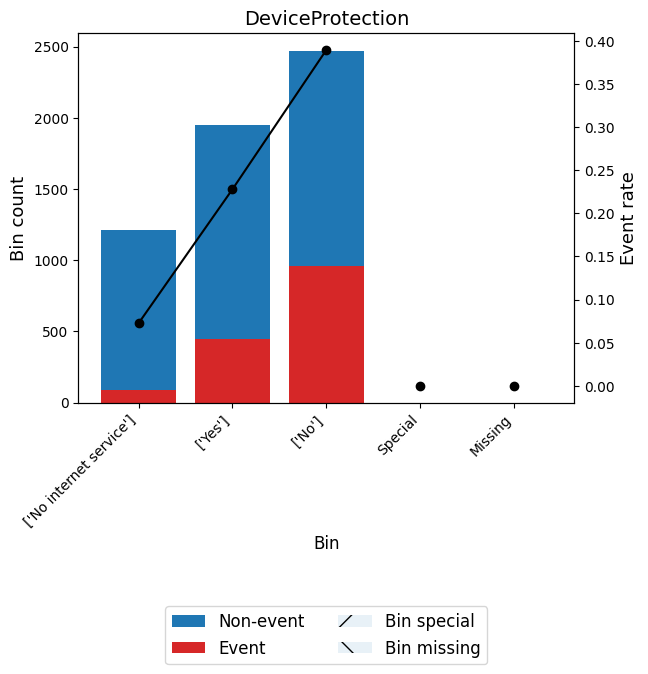

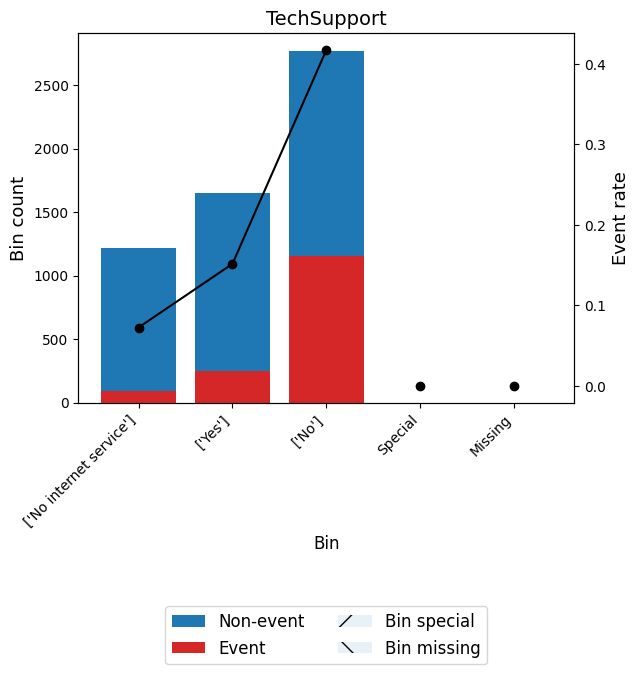

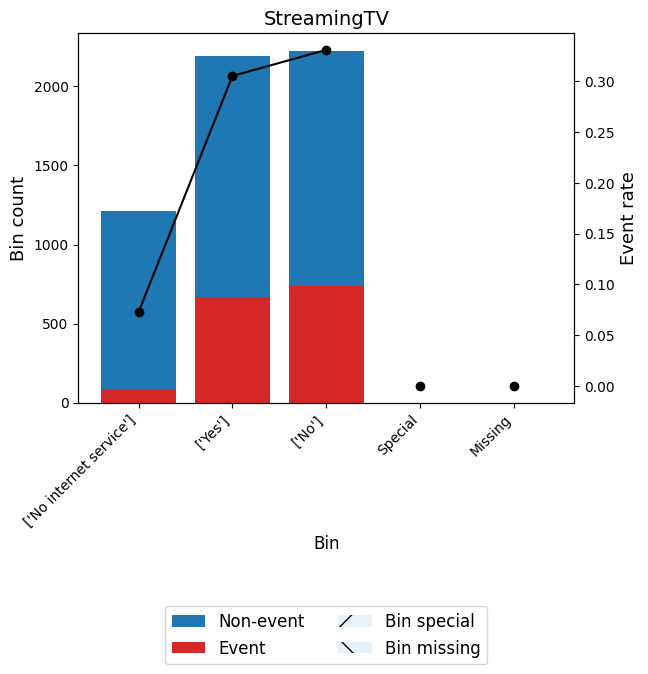

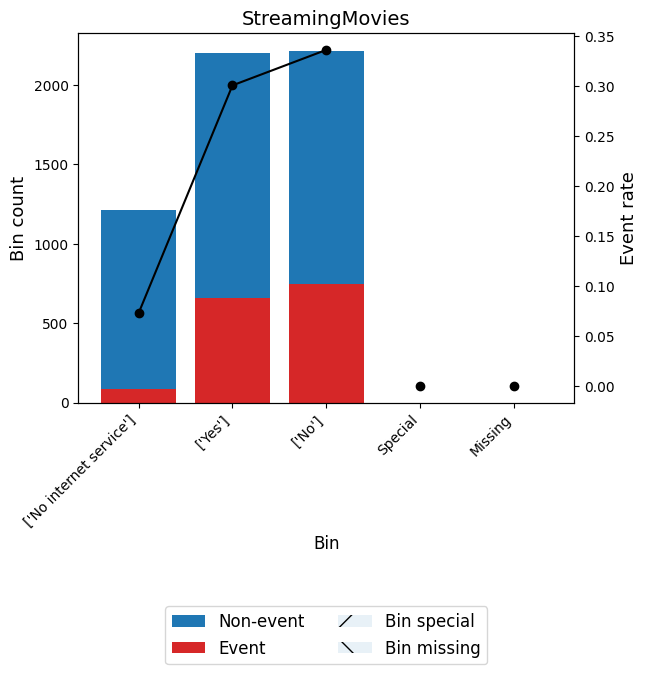

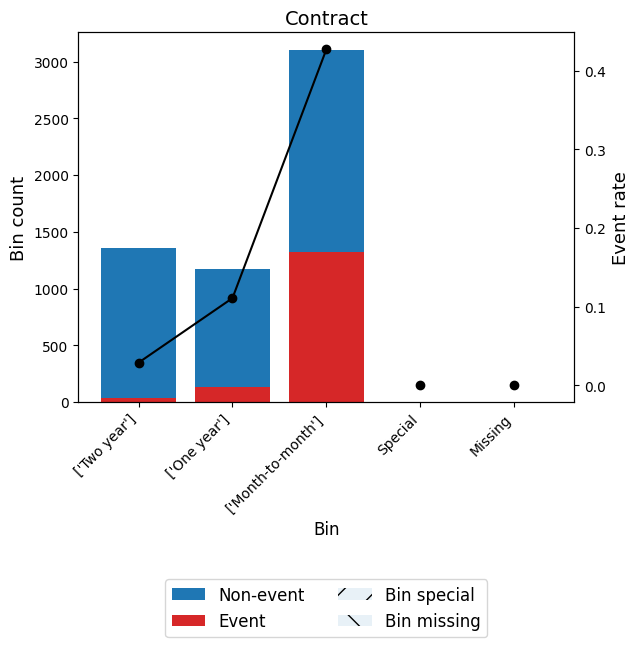

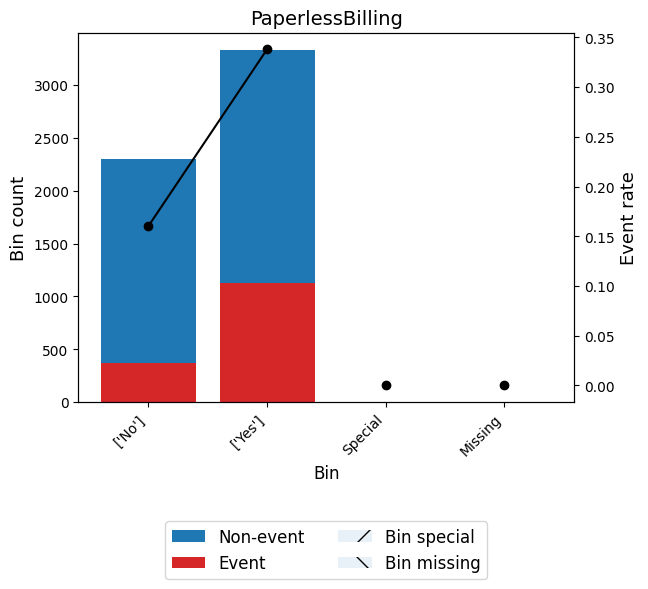

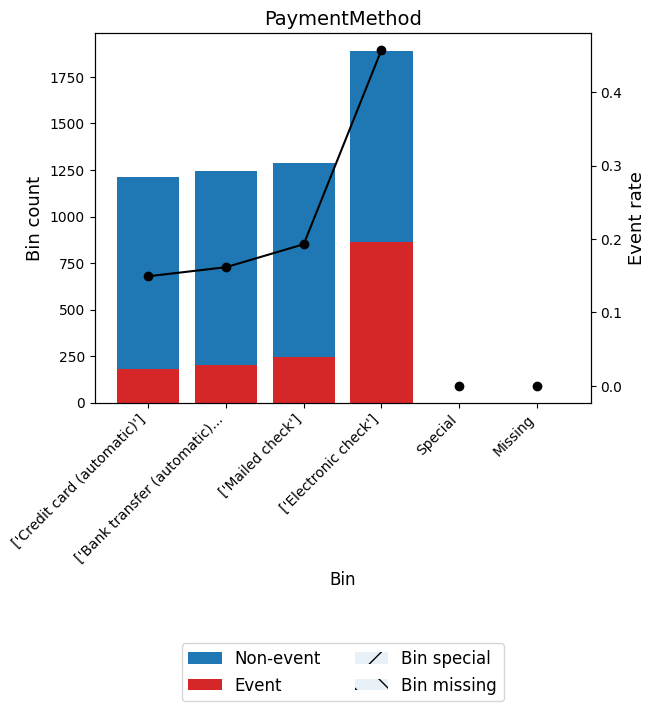

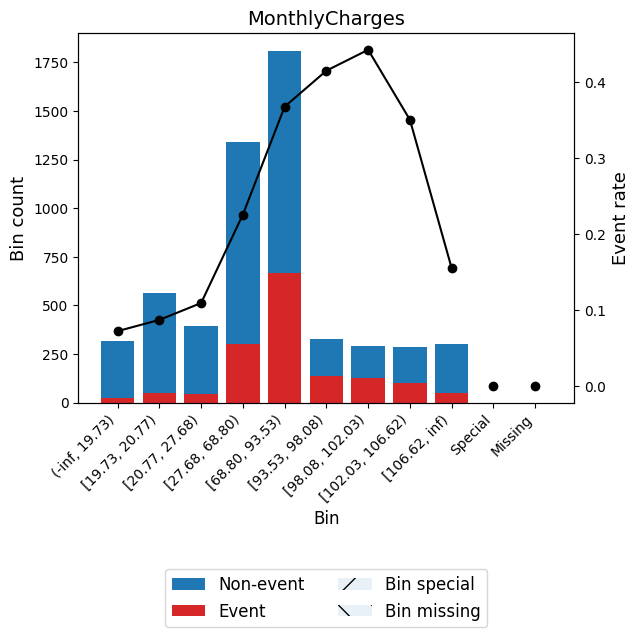

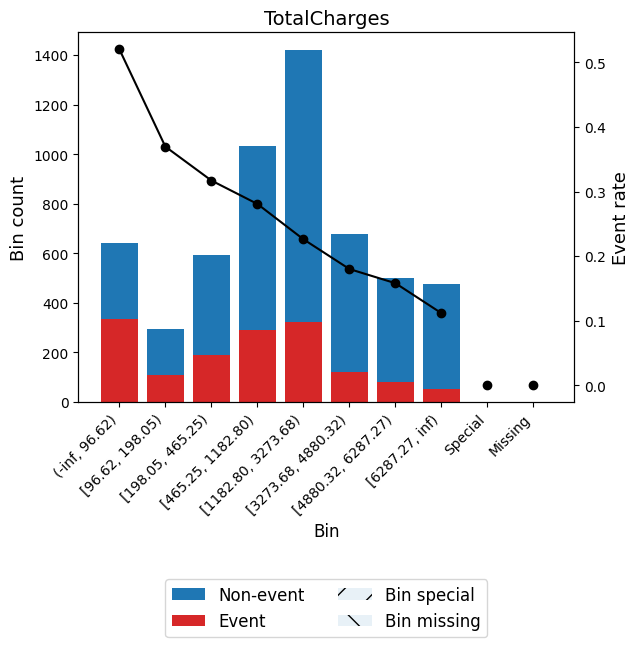

In [30]:
# Interpretation as the following
plot_binning_process(binning_model,X_train)

In [31]:
# Total Char
binning_model.summary().sort_values("iv",ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
14,Contract,categorical,OPTIMAL,True,3,1.241171,0.134991,0.479026,0.028135
4,tenure,numerical,OPTIMAL,True,10,0.835148,0.093782,0.472976,0.171729
8,OnlineSecurity,categorical,OPTIMAL,True,3,0.734735,0.087208,0.415078,0.426125
11,TechSupport,categorical,OPTIMAL,True,3,0.709701,0.084213,0.409561,0.463368
7,InternetService,categorical,OPTIMAL,True,3,0.634669,0.075089,0.395044,0.585646
9,OnlineBackup,categorical,OPTIMAL,True,3,0.537444,0.063238,0.357937,0.715013
10,DeviceProtection,categorical,OPTIMAL,True,3,0.498848,0.058521,0.338972,0.752965
16,PaymentMethod,categorical,OPTIMAL,True,4,0.481916,0.058802,0.352807,0.491198
17,MonthlyCharges,numerical,OPTIMAL,True,9,0.456642,0.054403,0.345804,0.162647
13,StreamingMovies,categorical,OPTIMAL,True,3,0.386691,0.044738,0.241236,0.797818


In [32]:
# Drop this low columns
col_low_iv = ["MultipleLines", "PhoneService", "gender"]
X_train = X_train.drop(col_low_iv, axis=1)

In [33]:
binning_model = get_optimal_bin_model(X_train, y_train, max_num_bin=10)

In [50]:
# Print Final Features X Count
print("Final Number of Features : ", len(binning_model.variable_names))

Final Number of Features :  16


In [35]:
# Dump model and summary
path_binning_model = os.path.join(PATH_DIR_MODEL, "binning/model.pkl")
path_binning_summary = os.path.join(PATH_DIR_MODEL, "binning/summary.csv")

dump_pickle(binning_model, path_binning_model)
binning_model.summary().to_csv(path_binning_summary)

## Modelling

- We are going to employ two main architecture we believe it's appropriate with our problem, also we added 
    - Optuna is an open-source framework for hyperparameter optimization that utilizes Bayesian optimization with the Tree-structured Parzen Estimator ([TPE](https://www.youtube.com/watch?v=bcy6A57jAwI&ab_channel=AIxplained)).

In [115]:
NameArchitecture = Literal["logistic_regression","xgboost"]

In [160]:
def calculate_metrics(y, y_prob, y_pred, round_decimals=3):
    """
    Compute evaluation metrics for a given dataset.
    
    Args:
        y (array-like): True labels.
        y_prob (array-like): Predicted probabilities for the positive class.
        y_pred (array-like): Predicted class labels.
        dataset_label (str): Label to identify the dataset type (e.g., 'train', 'test', 'validation').
        round_decimals (int, optional): Number of decimal places to round the metrics. Defaults to 4.
    
    Returns:
        tuple: A dictionary of metrics and a Pandas DataFrame summarizing the results.
    """

    # Compute various performance metrics
    dict_metrics = {
        'auc': roc_auc_score(y, y_prob),
        'accuracy' : accuracy_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'precision': precision_score(y, y_pred),
    }

    return dict_metrics

def get_cut_off_threshold(y_true, y_prob)->float:
    """
    Find the best threshold for maximizing weighted F1-score.
    
    Args:
        y_true (array-like): True labels.
        y_prob (array-like): Predicted probabilities.
    
    Returns:
        float: Best threshold value.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)

    # Compute F1-scores for each threshold
    f1_scores = [f1_score(y_true, y_prob >= t, average='weighted') for t in thresholds]

    # Find the threshold that maximizes weighted F1-score
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    return best_threshold

def get_confusion_matrix_sample(
    df: pd.DataFrame, 
    name_col_truth="y_true",
    name_col_pred="y_pred",
    name_col_prob="y_prob",
    sample_size=20
):
    """
    Extracts samples from a dataset based on confusion matrix categories (TP, TN, FP, FN).
    
    Args:
        df (pd.DataFrame): DataFrame containing true labels, predicted labels, and probabilities.
        name_col_truth (str): Column name for true labels. Default is 'y_true'.
        name_col_pred (str): Column name for predicted labels. Default is 'y_pred'.
        name_col_prob (str): Column name for predicted probabilities. Default is 'y_prob'.
        sample_size (int): Number of samples to return per category. Default is 20.

    Returns:
        pd.DataFrame: A subset of the DataFrame with labeled confusion matrix samples.
    """
    # Ensure numeric values for truth and prediction columns
    df[name_col_truth] = pd.to_numeric(df[name_col_truth], errors='coerce').fillna(0).astype(int)
    df[name_col_pred] = pd.to_numeric(df[name_col_pred], errors='coerce').fillna(0).astype(int)

    # Drop rows with NaN probability values
    df = df[df[name_col_prob].notna()]

    # Define conditions for confusion matrix categories
    conditions = {
        "True Positive": (df[name_col_truth] == 1) & (df[name_col_pred] == 1),
        "True Negative": (df[name_col_truth] == 0) & (df[name_col_pred] == 0),
        "False Positive": (df[name_col_truth] == 0) & (df[name_col_pred] == 1),
        "False Negative": (df[name_col_truth] == 1) & (df[name_col_pred] == 0),
    }

    # Sorting order for each category
    sort_orders = {
        "True Positive": True,
        "True Negative": False,
        "False Positive": True,
        "False Negative": False,
    }

    # Create labeled DataFrames
    df_samples = []
    for label, condition in conditions.items():
        df_subset = df.loc[condition].sort_values(name_col_prob, ascending=sort_orders[label]).assign(label=label)
        df_samples.append(df_subset.head(sample_size))

    # Print category counts
    print("\nCount of correct predictions:")
    print(f"True Positive: {conditions['True Positive'].sum()}")
    print(f"True Negative: {conditions['True Negative'].sum()}")

    print("\nCount of incorrect predictions:")
    print(f"False Positive: {conditions['False Positive'].sum()}")
    print(f"False Negative: {conditions['False Negative'].sum()}")

    return pd.concat(df_samples, axis=0)

In [188]:
# Define the folder to save the files
def upload_train_experiment(output_model:dict, path_output_folder:str):

    # Make directory if not existed
    os.makedirs(path_output_folder, exist_ok=True)

    best_model = output_model["best_model"]

    # Save the best model as a pickle file
    with open(os.path.join(path_output_folder, "model.pkl"), "wb") as f:
        pickle.dump(best_model, f)
    
    # Save the config as a text file
    dict_model_metadata = {
        "model_name" : str(best_model),
        "cut_off_threshold" : output_model["cut_off_threshold"],
    }
    with open(os.path.join(path_output_folder, "model_metadata.json"), "w") as f:
        json.dump(dict_model_metadata, f, indent=4)
    
    # Save model metrics as JSON

    dict_metric = {
        "train" : model_metrics_train,
        "val" : model_metrics_val,
    }
    with open(os.path.join(path_output_folder, "model_metric.json"), "w") as f:
        json.dump(dict_metric, f, indent=4)

    df_train_misclass = output_model["misclassification_train_example"]
    df_val_misclass = output_model["misclassification_val_example"]

    df_misclass = pd.concat([df_train_misclass.assign(split="train"), df_val_misclass.assign(split="val")], axis=0)
    
    df_misclass.to_csv(os.path.join(path_output_folder, "classification_sample.csv"), index=False)
    
    print(f"Files saved in {path_output_folder}/")

In [52]:
positive_rate = get_positive_rate(df_train, "Churn")
print(f"Positive Rate : {positive_rate * 100 : .2f}")

Positive Rate :  26.54%


In [64]:
get_class_weight_for_binary(y_train)

2.768561872909699

In [122]:
def tune_logistic_with_tpe(X_train, y_train, X_val, y_val, fixed_params: Dict):
    """
    Function for hyperparameter tuning to get the set with highest roc_auc_score using Tree-structured Parzen Estimator
    """
    def objective(trial):
        # Define hyperparameters to tune
        tuned_params = {
            'C': trial.suggest_float('C', 1e-5, 10, log=True),
            'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
        }
        
        # Ensure solver compatibility with penalty
        if tuned_params['solver'] == 'liblinear':
            tuned_params['penalty'] = trial.suggest_categorical('penalty', ['l1', 'l2'])
        else:
            tuned_params['penalty'] = 'l2'  # lbfgs only supports l2 penalty
        
        # Merge fixed and tuned parameters
        params = {**fixed_params, **tuned_params}
        
        # Train Logistic Regression model
        model = LogisticRegression(**params)
        model.fit(X_train, y_train)

        # Evaluate using ROC AUC score
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_pred_prob)

    # Optimize hyperparameters with Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    return study.best_params
    
def tune_xgboost_with_tpe(X_train, y_train, X_val, y_val, fixed_params: Dict, plot_importance_graph:bool=True):
    """
    Function for hyperparameter tuning to get the set with highest roc_auc_score using Tree-structured Parzen Estimator
    """
    def objective(trial):
        # Define hyperparameters to tune
        tuned_params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'gamma' : trial.suggest_float('gamma', 1e-3, 10, log=True),
            'min_child_weight' : trial.suggest_float('min_child_weight', 1, 10, log=True),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),            
            'lambda' : trial.suggest_float('lambda', 1e-3, 10, log=True),
        }
        # Merge fixed and tuned parameters
        params = {**fixed_params, **tuned_params}

        # Train XGBoost model
        model = XGBClassifier(**params)
        model.fit(X_train, y_train)

        # Evaluate using Gini score
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_pred_prob)

    # Optimize hyperparameters with Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    return study.best_params

def tune_with_tpe(X_train, 
                  y_train, 
                  X_val, 
                  y_val, 
                  name_architecture:NameArchitecture,
                 ):

    # Compute class weight
    scale_pos_weight = get_class_weight_for_binary(y_train, is_inverse=True)
    class_weight_dict = get_class_weight_mapping(y_train)

    # Instantiate model object with the best hyperparameter
    if name_architecture == "logistic_regression":
        param_fixed = {
            'random_state' : RANDOM_STATE,
            'class_weight' : class_weight_dict,
        }
        best_params = tune_logistic_with_tpe(X_train, y_train, X_val, y_val, param_fixed)
        params = {**param_fixed,**best_params}
        best_model = LogisticRegression(**params)
    
    elif name_architecture == "xgboost":
        param_fixed = {
            'random_state' : RANDOM_STATE,
            'scale_pos_weight': scale_pos_weight,
            'eval_metric' : 'logloss',
        }
        best_params = tune_xgboost_with_tpe(X_train, y_train, X_val, y_val, param_fixed)
        params = {**param_fixed,**best_params}
        best_model = XGBClassifier(**params)

    return best_model

In [163]:
def preprocess_data(df, binning_model):
    """Splits data into features and target, selects important features, and applies binning."""
    X, y = split_into_x_and_y(df)
    X = X[binning_model.variable_names]
    X_binned = binning_model.transform(X)
    return X_binned, y


def train_model(X_train, y_train, X_val, y_val, name_architecture:NameArchitecture):
    """Trains the model using the preprocessed training data."""
    # Get the best hyperparameter
    best_model = tune_with_tpe(X_train, y_train, X_val, y_val, name_architecture)
    best_model.fit(X_train, y_train)
    return best_model


def evaluate_model(model, X, y, cut_off_threshold):
    """Predicts probabilities and computes metrics for evaluation."""
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= cut_off_threshold).astype(int)
    metrics = calculate_metrics(y, y_prob, y_pred)
    return y_prob, y_pred, metrics


def generate_report(X, y, y_pred, y_prob):
    """Generates a report DataFrame with predictions and true values."""
    df_report = X.copy()
    df_report["y_true"] = y
    df_report["y_pred"] = y_pred
    df_report["y_prob"] = y_prob
    return df_report


def train(name_architecture: NameArchitecture):
    global binning_model, df_train, df_val, best_model
    
    # Preprocess data
    X_train_binned, y_train = preprocess_data(df_train, binning_model)
    X_val_binned, y_val = preprocess_data(df_val, binning_model)
    
    # Train model
    best_model = train_model(X_train_binned, y_train, X_val_binned, y_val, name_architecture)
    
    # Get optimal threshold
    y_train_prob = best_model.predict_proba(X_train_binned)[:, 1]
    cut_off_threshold = get_cut_off_threshold(y_train, y_train_prob)
    
    # Evaluate model
    y_train_prob, y_train_pred, model_metrics_train = evaluate_model(best_model, X_train_binned, y_train, cut_off_threshold)
    y_val_prob, y_val_pred, model_metrics_val = evaluate_model(best_model, X_val_binned, y_val, cut_off_threshold)
    
    # Generate reports
    df_train_report = generate_report(df_train[binning_model.variable_names], y_train, y_train_pred, y_train_prob)
    df_val_report = generate_report(df_val[binning_model.variable_names], y_val, y_val_pred, y_val_prob)
  
    # Return output
    return {
        "best_model": best_model,
        "cut_off_threshold": cut_off_threshold,
        "model_metric_train": model_metrics_train,
        "model_metric_val": model_metrics_val,
        "misclassification_train_example": get_confusion_matrix_sample(df_train_report),
        "misclassification_val_example": get_confusion_matrix_sample(df_val_report),
    }

In [190]:
output_lr = train("logistic_regression")

path_dir_model_lr = os.path.join(PATH_DIR_MODEL, "classifier/logistic_regression")
upload_train_experiment(output_lr, path_dir_model_lr)

Files saved in ../artifact/model/classifier/logistic_regression/


In [191]:
output_xg = train("xgboost")

path_dir_model_xg = os.path.join(PATH_DIR_MODEL, "classifier/xgboost")
upload_train_experiment(output_xg, path_dir_model_xg)

[I 2025-03-09 17:15:45,019] A new study created in memory with name: no-name-39f23f4a-d60e-40ea-8dae-0e4637240876
[I 2025-03-09 17:15:48,012] Trial 0 finished with value: 0.83589507545589 and parameters: {'learning_rate': 0.0025849098575491986, 'n_estimators': 1900, 'max_depth': 8, 'gamma': 0.010611337126337494, 'min_child_weight': 1.1474026307411354, 'subsample': 0.8140144187682562, 'colsample_bytree': 0.8331663112796054, 'lambda': 0.5073198128293611}. Best is trial 0 with value: 0.83589507545589.
[I 2025-03-09 17:15:48,165] Trial 1 finished with value: 0.8476453004271869 and parameters: {'learning_rate': 0.008618156377064723, 'n_estimators': 100, 'max_depth': 8, 'gamma': 0.03959465817988581, 'min_child_weight': 9.143240479871345, 'subsample': 0.8677737599290897, 'colsample_bytree': 0.7029219497928316, 'lambda': 1.8764102106321794}. Best is trial 1 with value: 0.8476453004271869.
[I 2025-03-09 17:15:50,544] Trial 2 finished with value: 0.8428976303023408 and parameters: {'learning_rat


Count of correct predictions:
True Positive: 1030
True Negative: 3545

Count of incorrect predictions:
False Positive: 594
False Negative: 465

Count of correct predictions:
True Positive: 128
True Negative: 425

Count of incorrect predictions:
False Positive: 92
False Negative: 59


TypeError: Object of type float32 is not JSON serializable

In [164]:
output_lr = train("logistic_regression")

[I 2025-03-09 16:40:45,861] A new study created in memory with name: no-name-4beafc2a-1585-4812-bc40-755bde0cdb42
[I 2025-03-09 16:40:45,869] Trial 0 finished with value: 0.8375810672431449 and parameters: {'C': 0.00031250826627433366, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8375810672431449.
[I 2025-03-09 16:40:45,882] Trial 1 finished with value: 0.8518551081413751 and parameters: {'C': 0.29001780062126564, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.8518551081413751.
[I 2025-03-09 16:40:45,886] Trial 2 finished with value: 0.5 and parameters: {'C': 6.455407415500213e-05, 'solver': 'liblinear', 'penalty': 'l1'}. Best is trial 1 with value: 0.8518551081413751.
[I 2025-03-09 16:40:45,892] Trial 3 finished with value: 0.5 and parameters: {'C': 3.631060982460963e-05, 'solver': 'liblinear', 'penalty': 'l1'}. Best is trial 1 with value: 0.8518551081413751.
[I 2025-03-09 16:40:45,902] Trial 4 finished with value: 0.8516378944755324 and parameters: {'C': 


Count of correct predictions:
True Positive: 955
True Negative: 3579

Count of incorrect predictions:
False Positive: 560
False Negative: 540

Count of correct predictions:
True Positive: 124
True Negative: 434

Count of incorrect predictions:
False Positive: 83
False Negative: 63


## Inference
- Let's make an inference pipeline which take input as these 16 fields

In [200]:
model_binning.variable_names

['SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [194]:
path_model_classifier = os.path.join(PATH_DIR_MODEL, "classifier/xgboost/model.pkl")
path_model_binning = os.path.join(PATH_DIR_MODEL, "binning/model.pkl")

with open(path_model_binning, 'rb') as pickle_file:
    model_binning = pickle.load(pickle_file)

with open(path_model_classifier, 'rb') as pickle_file:
    model_classifier = pickle.load(pickle_file)

In [196]:
df_val

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5905,1628-BIZYP,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.00,85.00,0
6946,9013-AQORL,Female,0,No,Yes,48,No,No phone service,DSL,No,...,Yes,No,No,Yes,Month-to-month,No,Credit card (automatic),45.55,2108.35,0
1890,6770-XUAGN,Female,0,Yes,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.00,21.00,1
1216,0040-HALCW,Male,0,Yes,Yes,54,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),20.40,1090.60,0
6363,8778-LMWTJ,Female,0,No,No,9,Yes,No,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.85,708.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,4821-WQOYN,Female,0,Yes,Yes,72,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),20.10,1326.25,0
437,4376-KFVRS,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.20,0
5283,0997-YTLNY,Female,0,No,Yes,19,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,No,Mailed check,48.80,953.65,0
5592,5063-IUOKK,Male,0,No,No,13,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.75,265.75,0


In [199]:
df_val_binned = model_binning.transform(df_val)
df_val_pred = model_classifier.predict(df_val_binned)
df_val_pred

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,

In [202]:
df_val.iloc[0].to_json()

'{"customerID":"1628-BIZYP","gender":"Male","SeniorCitizen":0,"Partner":"No","Dependents":"No","tenure":1,"PhoneService":"Yes","MultipleLines":"No","InternetService":"Fiber optic","OnlineSecurity":"No","OnlineBackup":"Yes","DeviceProtection":"No","TechSupport":"No","StreamingTV":"No","StreamingMovies":"Yes","Contract":"Month-to-month","PaperlessBilling":"Yes","PaymentMethod":"Electronic check","MonthlyCharges":85.0,"TotalCharges":85.0,"Churn":0}'